In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# export
from decode_fish.imports import *

# os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict
import torch.nn as nn
import torch.nn.functional as F
import torch.tensor as T
from decode_fish.funcs.predict import *

from omegaconf import open_dict
from hydra import compose, initialize
from decode_fish.funcs.merfish_eval import *

import h5py
from decode_fish.funcs.routines import *

initialize(config_path="../config")

hydra.initialize()

## Generate Data

In [4]:
cfg = OmegaConf.load(f'../config/experiment//MERFISH_ci_2d_sim1.yaml')

crop_sz = 256
cfg.training.bs = 3
cfg.random_crop.crop_sz = crop_sz
cfg.data_path.image_shape = [16,1,crop_sz,crop_sz]
_, decode_dl = get_dataloader(cfg)
_, noise, micro = load_psf_noise_micro(cfg)

Crop size larger than volume in at least one dimension. Crop size changed to (1, 256, 256)
1 volumes


/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [6]:
bench_df, code_ref, targets = get_benchmark()
code_inds = np.stack([np.nonzero(c)[0] for c in code_ref])

13832


In [3]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data3/'

densities = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
intensities = [1., 0.5, 0.25, 0.125]
# intensities = [0.8, 0.4, 0.2, 0.12]

In [11]:
from decode_fish.engine.point_process import *
from decode_fish.funcs.output_trafo import *

gt_col = []
    
for d in densities:
    for i in intensities:

        k = f'dens_{d}_int_{i}'
        print(k)

        with h5py.File(out_dir+k+'.h5', 'w') as f:

            with torch.no_grad():

                x, local_rate, background = next(iter(decode_dl))
                sim_vars = PointProcessUniform(local_rate*0 + d, cfg.intensity_dist.int_conc*i, cfg.intensity_dist.int_rate, 
                                               cfg.intensity_dist.int_loc, channels=16, n_bits=4, sim_z=False, codebook=torch.tensor(code_inds), int_option=3).sample(from_code_book=True, phasing=cfg.exp_type.phasing)
                xsim = micro(*sim_vars, add_noise=False)
                xsimn = micro.noise(xsim, background).sample()

                gt_vars = sim_vars[:-1]
                gt_df = sample_to_df(*gt_vars, px_size_zyx=[1.,1.,1.])

            gt_df = get_code_from_ints(gt_df, code_ref, targets, int_str='', p_str='')
            gt_df = gt_df.drop('gene', 1) # can't store in hd5
            gt_df = px_to_nm(gt_df)
            gt_df = exclude_borders(gt_df, border_size_zyx=[0,500,500], img_size=[crop_sz*100,crop_sz*100,crop_sz*100])

            add_df_to_hdf5(f, 'locations', gt_df)          
            f.create_dataset('frames', data=cpu(xsimn))

dens_0.01_int_1.0


/groups/turaga/home/speisera/Dropbox (mackelab)/Artur/WorkDB/deepstorm/decode_fish/decode_fish/funcs/output_trafo.py:19: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370141920/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  b_inds = torch.cat([torch.tensor([0], device=x_os.device),((x_os[1:] - x_os[:-1]).nonzero() + 1)[:,0],
/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


dens_0.01_int_0.5
dens_0.01_int_0.25
dens_0.01_int_0.125
dens_0.025_int_1.0
dens_0.025_int_0.5
dens_0.025_int_0.25
dens_0.025_int_0.125
dens_0.05_int_1.0
dens_0.05_int_0.5
dens_0.05_int_0.25
dens_0.05_int_0.125
dens_0.075_int_1.0
dens_0.075_int_0.5
dens_0.075_int_0.25
dens_0.075_int_0.125
dens_0.1_int_1.0
dens_0.1_int_0.5
dens_0.1_int_0.25
dens_0.1_int_0.125
dens_0.125_int_1.0
dens_0.125_int_0.5
dens_0.125_int_0.25
dens_0.125_int_0.125
dens_0.15_int_1.0
dens_0.15_int_0.5
dens_0.15_int_0.25
dens_0.15_int_0.125


In [35]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data3/'
files = glob.glob(out_dir+'/*.h5')
base_str = 'bsub -gpu "num=1" -q gpu_rtx -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_sim_eval.py '

with open('run_slurm.sh', 'w') as f:
    for n in files:
        if 'int_0.25' in n or 'int_0.125' in n:
            name = n.split('/')[-1]
            print(name)
            f.write(base_str + f'data_file={name}' + ' \n')

dens_0.075_int_0.125.h5
dens_0.025_int_0.25.h5
dens_0.01_int_0.125.h5
dens_0.05_int_0.125.h5
dens_0.125_int_0.25.h5
dens_0.025_int_0.125.h5
dens_0.15_int_0.125.h5
dens_0.1_int_0.125.h5
dens_0.01_int_0.25.h5
dens_0.075_int_0.25.h5
dens_0.15_int_0.25.h5
dens_0.05_int_0.25.h5
dens_0.125_int_0.125.h5
dens_0.1_int_0.25.h5


In [62]:
!ls /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data3/

cinfsim_1		 dens_0.025_int_1.0.h5	  dens_0.125_int_0.5.h5
cinfsim_1b		 dens_0.05_int_0.125.h5   dens_0.125_int_1.0.h5
cinfsim_1c		 dens_0.05_int_0.25.h5	  dens_0.15_int_0.125.h5
cinfsim_1d		 dens_0.05_int_0.5.h5	  dens_0.15_int_0.25.h5
dens_0.01_int_0.125.h5	 dens_0.05_int_1.0.h5	  dens_0.15_int_0.5.h5
dens_0.01_int_0.25.h5	 dens_0.075_int_0.125.h5  dens_0.15_int_1.0.h5
dens_0.01_int_0.5.h5	 dens_0.075_int_0.25.h5   dens_0.1_int_0.125.h5
dens_0.01_int_1.0.h5	 dens_0.075_int_0.5.h5	  dens_0.1_int_0.25.h5
dens_0.025_int_0.125.h5  dens_0.075_int_1.0.h5	  dens_0.1_int_0.5.h5
dens_0.025_int_0.25.h5	 dens_0.125_int_0.125.h5  dens_0.1_int_1.0.h5
dens_0.025_int_0.5.h5	 dens_0.125_int_0.25.h5   sim_2c


In [4]:
out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data3/'
intensities = [0.25, 0.125]
files = glob.glob(out_dir+'cinfsim_1d/*')
# files = glob.glob(out_dir+'sim_2c/*')

# out_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data2/'
# intensities = [0.8, 0.4, 0.2, 0.12]
# files = glob.glob(out_dir+'sim_2b/*')

with h5py.File(files[0], 'a') as f:
    print(f.keys())
#     print(get_df_from_hdf5(f['old_loss:True']['perf_int']))

<KeysViewHDF5 ['istdeco', 'seed:0', 'seed:1', 'seed:2', 'seed:3', 'seed:4']>


In [5]:
densities = [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15]
# intensities = [0.25, 0.125]
intensities = [0.125, 0.25, 0.5, 1.0]

with h5py.File(files[0], 'r') as f:
    mod_keys = list(f.keys())

jacs = {k:np.zeros([len(intensities), len(densities)]) for k in mod_keys}

for f in files:
    with h5py.File(f, 'r') as h:
        for m in mod_keys:
            
            if 'istdeco' in m:
                perf_str = 'perf'
            else:
                perf_str = 'perf'
#                 perf_str = 'perf_p'

            k = f.split('/')[-1].split('.h5')[0] 
            d = k.split('_')[1]
            i = k.split('_')[3]
            # locs = get_df_from_hdf5(f['evaluations'][k]['old_loss:False']['locations_int'])
#             print(m, h[m].keys())
            perf = get_df_from_hdf5(h[m][perf_str])
            
            if float(i) in intensities:
                jacs[m][intensities.index(float(i)),densities.index(float(d))] = perf['jaccard'].values[0]
            
            if k == 'dens_0.1_int_1.0':
                print(m)
                display(perf)

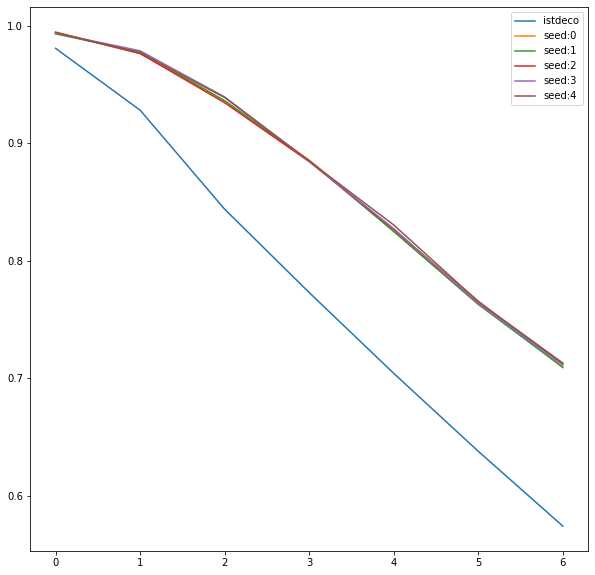

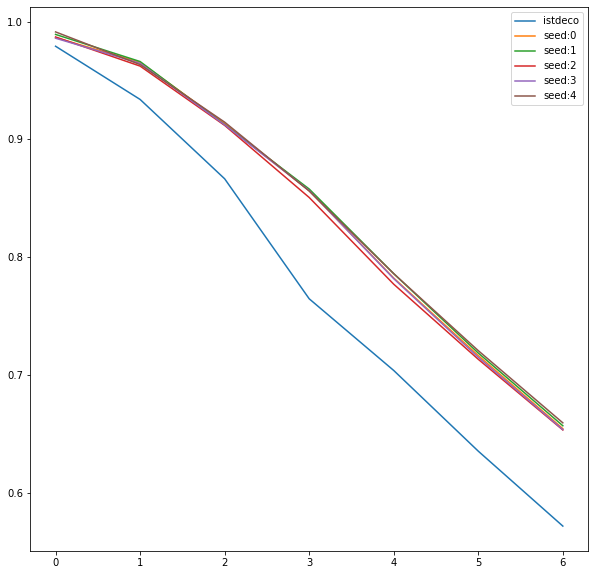

In [39]:
for i in range(len(intensities)):
    plt.figure(figsize=(10,10))
    for m in mod_keys:
        plt.plot(jacs[m][i], label=m)
    plt.legend()
    plt.show()

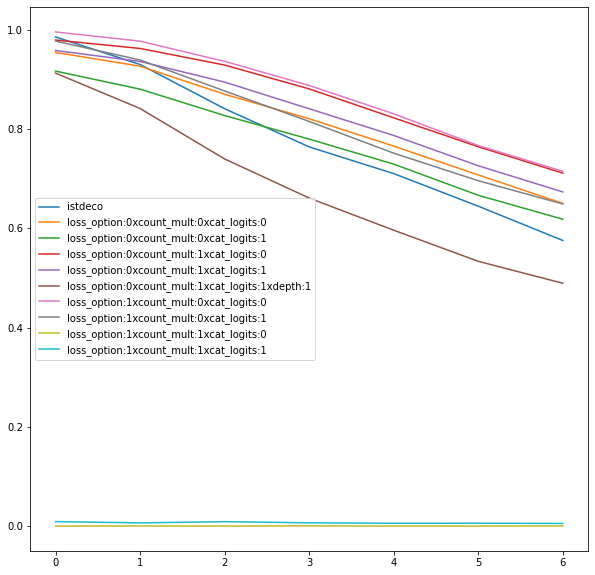

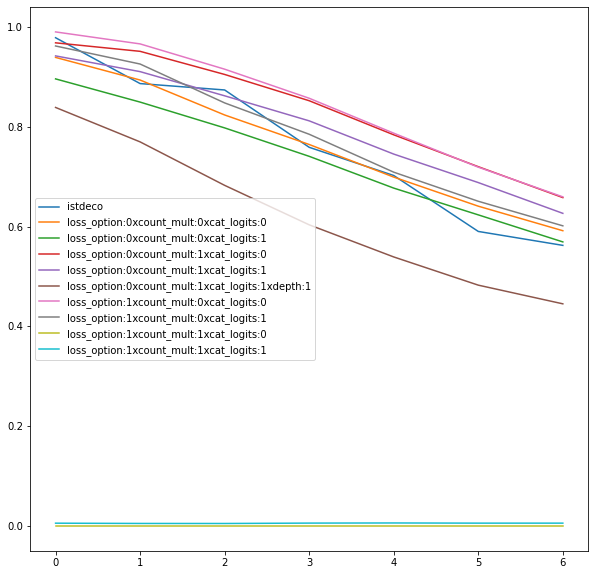

In [33]:
for i in range(len(intensities)):
    plt.figure(figsize=(10,10))
    for m in mod_keys:
        plt.plot(jacs[m][i], label=m)
    plt.legend()
    plt.show()

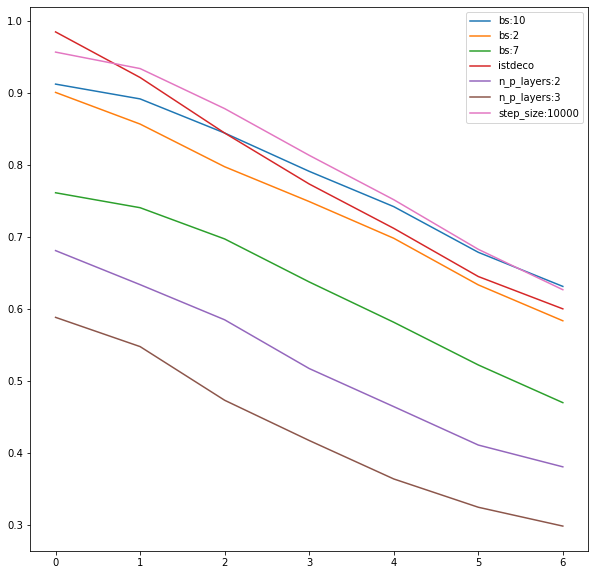

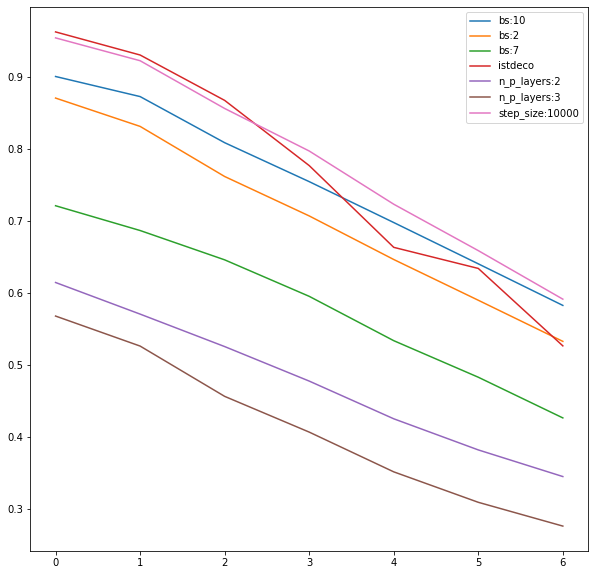

In [18]:
for i in range(len(intensities)):
    plt.figure(figsize=(10,10))
    for m in mod_keys:
        plt.plot(jacs[m][i], label=m)
    plt.legend()
    plt.show()

bsub -gpu "num=1" -q gpu_any -o logs/ofish.log -e logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/merfish_sim_eval.py 

In [6]:
model_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/models/fishcod/MERFISH_starfish/sweep_cinfsim_1d/'
m = 'seed:0'
model_cfg = OmegaConf.load(f'{model_dir}/{m}/train.yaml')

In [7]:
path = Path(model_cfg.output.save_dir)
model = hydra.utils.instantiate(model_cfg.model)
model = load_model_state(model, path/'model.pkl')
_ = model.cuda()

/groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev2/lib/python3.7/site-packages/torch/cuda/__init__.py:81: UserWarning: 
    Found GPU2 NVS 510 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


In [8]:
with h5py.File('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data3/' + 'dens_0.01_int_0.25.h5', 'r') as f:
    xsimn = f['frames'][()]
res_dict1 = model.tensor_to_dict(model(torch.tensor(xsimn).cuda()))
with h5py.File('/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/data/merfish_sims/sim_data3/' + 'dens_0.15_int_0.25.h5', 'r') as f:
    xsimn = f['frames'][()]
res_dict2 = model.tensor_to_dict(model(torch.tensor(xsimn).cuda()))

In [10]:
res_dict1.keys()

dict_keys(['logits', 'xyzi_mu', 'xyzi_sigma', 'background'])

In [11]:
res_dict1['xyzi_mu'].shape

torch.Size([3, 4, 1, 256, 256])

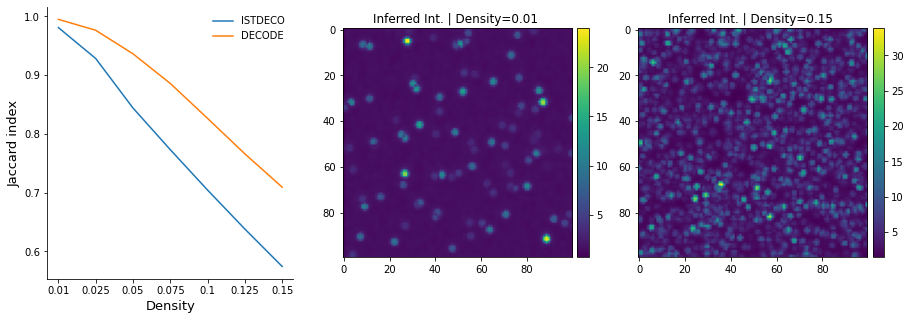

In [16]:
plt.figure(figsize=(15,5))
import seaborn as sns
plt.subplot(131)
plt.plot(jacs['istdeco'][1], label='ISTDECO')
plt.plot(jacs['seed:0'][1], label='DECODE')
plt.legend(frameon=False)
plt.xlabel('Density', size=13)
plt.xticks(np.arange(7),densities)
plt.ylabel('Jaccard index', size=13)
sns.despine()
plt.subplot(132)
im = plt.imshow((res_dict1['xyzi_mu'][0,3,0,:100,:100]).detach().cpu())
plt.title('Inferred Int. | Density=0.01 ')
add_colorbar(im)
plt.subplot(133)
im = plt.imshow((res_dict2['xyzi_mu'][0,3,0,:100,:100]).detach().cpu())
plt.title('Inferred Int. | Density=0.15 ')
add_colorbar(im)

In [17]:
print(jacs['istdeco'][1])

[0.98093091 0.92831697 0.84401795 0.77308976 0.70431021 0.63796596
 0.57433133]


In [18]:
intensities

[0.125, 0.25, 0.5, 1.0]